In [1]:
# external dependency
import sys
sys.path.append('../')
import nbimporter
from _11_Others import External_Condition as EC
from _03_HCLoad_and_Envelope import Heating_Cooling_Floor_Area as HCFA
from _09_Natural_Energy_System import Loads_and_Water_Temp as LWT

import math
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

Importing Jupyter notebook from ..\_11_Others\External_Condition.ipynb
Importing Jupyter notebook from ..\_03_HCLoad_and_Envelope\Heating_Cooling_Floor_Area.ipynb
Importing Jupyter notebook from ..\_09_Natural_Energy_System\Loads_and_Water_Temp.ipynb


# Outside Air Intake Ventilation System through Underfloor Space / 床下空間を経由して外気を導入する換気方式

## 1. Introduction

This calculation depends on the specification of "Chapter 3 - 1 - Apx.D Heating & Cooling Load and Envelope Performance - General - Appendix D Outside Air Intake Ventilation System" in BRI.

## 2. Type

## 3. Functions

### 3.1 Heating & Cooling Load Reduction / 暖冷房負荷削減量

if $\Delta L'_{H,d,t,i}$ is 0 and $\Delta L'_{CS,d,t,i}$ is 0:

$$ \begin{align}
    \displaystyle \Delta L'_{H,uf,i} & = 0 \nonumber
\end{align} $$

$$ \begin{align}
    \displaystyle \Delta L'_{CS,uf,i} & = 0 \nonumber
\end{align} $$

if $\Delta L'_{H,d,t,i}$ is lager than 0:

$$ \begin{align}
    \displaystyle \Delta L'_{H,uf,i} & = \rho_{air} \times Cp_{air} \times V_{i} \times ( \theta_{uf} - \theta' ) \times 10^{-3} \nonumber \\
    & - U_s \times A_{s,ufvnt,i} \times ( \theta_{in} - \theta_{uf} ) \times 3.6 \times 10^{-3} \nonumber \\
    & + U_{s,vert} \times A_{s,ufvnt,i} \times ( \theta_{in} - \theta_{ex} ) \times H_{floor} \times 3.6 \times 10^{-3} \nonumber
\end{align} $$


$$ \begin{align}
    \displaystyle \Delta L'_{CS,uf,i} & = 0 \nonumber
\end{align} $$

if $\Delta L'_{CS,d,t,i}$ is lager than 0:

$$ \begin{align}
    \displaystyle \Delta L'_{H,uf,i} & = 0 \nonumber
\end{align} $$

$$ \begin{align}
    \displaystyle \Delta L'_{CS,uf,i} & = \rho_{air} \times Cp_{air} \times V_{i} \times ( \theta' - \theta_{uf} ) \times 10^{-3} \nonumber \\
    & + U_s \times A_{s,ufvnt,i} \times ( \theta_{in} - \theta_{uf} ) \times 3.6 \times 10^{-3} \nonumber \\
    & - U_{s,vert} \times A_{s,ufvnt,i} \times ( \theta_{in} - \theta_{ex} ) \times H_{floor} \times 3.6 \times 10^{-3} \nonumber
\end{align} $$

$ \Delta L'_{H,uf,i} $ is the hourly heating load reduction by outside air intake ventilation system through underfloor heating & cooling area  $i$ / 暖冷房区画$i$の床下空間を経由して外気を導入する換気方式による1時間当たりの暖房負荷削減量 (MJ/h);  
$ \Delta L'_{CS,uf,i} $ is the hourly sensible cooling load reduction by outside air intake ventilation system through underfloor heating & cooling area $i$ / 暖冷房区画$i$の床下空間を経由して外気を導入する換気方式による1時間当たりの冷房顕熱負荷削減量 (MJ/h);  
$ \rho_{air} $ is the air density / 空気の密度 (kg/m<sup>3</sup>, 1.2);  
$ Cp_{air} $ is the specific heat of air / 空気の比熱 (kJ/kgK, 1.006);  
$ V_{i} $ is the hourly ventiration amount of heating & cooling area $i$ / 暖冷房区画$i$の1時間当たりの換気量 (m<sup>3</sup>/h);  
$ V_{A} $ is the hourly ventiration amount / 1時間当たりの換気量 (m<sup>3</sup>/h);  
$ U_s $ is the thermal transmittance of floor / 床の熱貫流率 (W/m<sup>2</sup>K);  
$ U_{s,vert} $ is the vertual thermal tranmittance of floor assumed when the heating & cooling load were calculated / 暖冷房負荷計算時に想定した床の熱貫流率(W/m<sup>2</sup>K);  
$ U_{gf} $ is the thermal transmittance of the ground / 地盤の熱貫流率 (W/m<sup>2</sup>K);  
$ \psi $ is the linier thermal transmittance of the basement / 基礎の線熱貫流率 (W/mK);  
$ A_{s,ufvnt,i} $ is the floor area of heating & cooling area $i$ adjacent to the under floor space with outside air intake / 暖冷房区画$i$の外気を導入する床下空間に接する床の面積 (m<sup>2</sup>);  
$ A_{s,ufvnt,A} $ is the floor area adjacent to the under floor space with outside air intake / 外気を導入する床下空間に接する床の面積 (m<sup>2</sup>);  
$ L_{uf} $ is the perimeter length of the basement of the under floor space with outside air intake / 外気を導入する床下空間の基礎外周長さ (m);  
$ \theta_{ex} $ is the outside air temperature / 外気温度 (degree C);  
$ \theta_{uf} $ is the temperature in the undefloor space / 床下温度 (<sup>o</sup>C);  
$ \theta_{in} $ is the inside air temperature / 室内温度 (degree C);  
$ \theta_g $ is the ground temperature / 地盤温度 (degree C);  
$ \theta' $ is the reference temperature / 基準温度 (degree C).  

In [2]:
def get_delta_L_H_uf_i(V_i, Theta_uf, Theta_ex, Theta_dash, A_s_ufvnt_i, U_s_vert, L_dash_H ):
    U_s      = 2.223 # W/m2K
    Theta_in = 20.0  # degree C
    rho_air  = 1.20  # kg/m3
    Cp_air   = 1.006 # kJ/kgK
    
    if 0 < L_dash_H:
        return   rho_air * Cp_air * V_i * ( Theta_uf - Theta_dash ) * ( 1/1000 ) \
               - U_s * A_s_ufvnt_i * ( Theta_in - Theta_uf ) * ( 3.6/1000 ) \
               + U_s_vert * A_s_ufvnt_i * ( Theta_in - Theta_ex ) * 0.7 * ( 3.6/1000 )
    else:
        return 0

In [3]:
def get_delta_L_CS_uf_i(V_i, Theta_uf, Theta_ex, Theta_dash, A_s_ufvnt_i, U_s_vert, L_dash_CS ):
    U_s      = 2.223 # W/m2K
    Theta_in = 27.0  # degree C
    rho_air  = 1.20  # kg/m3
    Cp_air   = 1.006 # kJ/kgK
    
    if 0 < L_dash_CS:
        return - rho_air * Cp_air * V_i * ( Theta_uf - Theta_dash ) * ( 1/1000 ) \
               + U_s * A_s_ufvnt_i * ( Theta_in - Theta_uf ) * ( 3.6/1000 ) \
               - U_s_vert * A_s_ufvnt_i * ( Theta_in - Theta_ex ) * 0.7 * ( 3.6/1000 )
    else:
        return 0

#### Example

In [4]:
get_delta_L_H_uf_i( V_i = 288.0, Theta_uf = 22.59036359199709, Theta_ex = 7.2, Theta_dash = 30.89764504357676, A_s_ufvnt_i = 30.0, U_s_vert = 0.554, L_dash_H = 4.886229999999999 )

-1.7302228758629004

In [5]:
get_delta_L_CS_uf_i( V_i = 288.0, Theta_uf = 22.59036359199709, Theta_ex = 7.2, Theta_dash = 30.89764504357676, A_s_ufvnt_i = 30.0, U_s_vert = 0.554, L_dash_CS = 0 )

0

### 3.2 Temperature in the Undefloor Space / 床下温度

$$ 
\begin{equation*}
   \theta_{uf,d,t} = \displaystyle \frac{\rho_{air} Cp_{air} V_{A} \theta_{sa} + \left( \displaystyle \sum_{i=1}^{12} U_{s} A_{s,ufvnt,i} H^{*}_{i} \theta^{*}_{i} + \psi L_{uf} \theta_{ex} + U_{gf} A_{s,ufvnt,A} \theta_{g} \right) \times 3.6}{\rho_{air} Cp_{air} V_{A} + \left( \displaystyle \sum_{i=1}^{12} U_{s} A_{s,ufvnt,i} H^{*}_{i} + \psi L_{uf} + U_{bf} A_{s,ufvnt,A} \right) \times 3.6}
\end{equation*}
$$

$ \rho_{air} $ is the air density / 空気の密度 (kg/m<sup>3</sup>, 1.2);  
$ Cp_{air} $ is the specific heat of air / 空気の比熱 (kJ/kgK, 1.006);    
$ V_{A} $ is the hourly ventiration amount / 床下または居室へ導入する外気の風量の合計 (m<sup>3</sup>/h);  
$ U_s $ is the thermal transmittance of floor / 床の熱貫流率 (W/m<sup>2</sup>K);  
$ U_{gf} $ is the thermal transmittance of the ground / 地盤の熱貫流率 (W/m<sup>2</sup>K);  
$ \psi $ is the linier thermal transmittance of the basement / 基礎の線熱貫流率 (W/mK);  
$ A_{s,ufvnt,i} $ is the floor area of heating & cooling area $i$ adjacent to the under floor space with outside air intake / 暖冷房区画$i$の外気を導入する床下空間に接する床の面積 (m<sup>2</sup>);  
$ A_{s,ufvnt,A} $ is the floor area adjacent to the under floor space with outside air intake / 外気を導入する床下空間に接する床の面積 (m<sup>2</sup>);  
$ L_{uf} $ is the perimeter length of the basement of the under floor space with outside air intake / 外気を導入する床下空間の基礎外周長さ (m);  
$ \theta_{ex} $ is the outside air temperature / 外気温度 (degree C);  
$ \theta_{uf} $ is the temperature in the undefloor space / 床下温度 (<sup>o</sup>C);  
$ \theta_g $ is the ground temperature / 地盤温度 (degree C);  
$ \theta^{*} $ is the reference temperature / 参照空気温度 (degree C);  
$ H^{*} $ is the reference coefficient of temperature difference / 参照温度差係数 (-).

In [6]:
def get_theta_uf(V_A, theta_sa, A_s_ufvnt_s, H_aster_s, theta_aster_s, psi, L_uf, theta_ex, A_s_ufvnt_A, theta_g):
    rho_air  = 1.20  # kg/m3
    Cp_air   = 1.006 # kJ/kgK
    U_s      = 2.223 # W/m2K
    U_gf     = 2.223 # W/m2K
    
    return (rho_air * Cp_air * V_A * theta_sa \
                + (sum([U_s * A_s_ufvnt_s[i] * H_aster_s[i] * theta_aster_s[i] for i in range(0,12,1)]) \
                + psi * L_uf * theta_ex + U_gf * A_s_ufvnt_A * theta_g) * 3.6) \
            / (rho_air * Cp_air * V_A \
                + (sum([U_s * A_s_ufvnt_s[i] * H_aster_s[i] for i in range(0,12,1)]) \
                + psi * L_uf + U_gf * A_s_ufvnt_A) * 3.6)

In [7]:
def get_theta_aster(L_dash_H, L_dash_CS, theta_ex):
    if L_dash_H == 0 and L_dash_CS == 0:
        return theta_ex
    elif 0 < L_dash_H:
        theta_prst_H = 20  # degree C
        return theta_prst_H
    elif 0 < L_dash_CS:
        theta_prst_C = 27  # degree C
        return theta_prst_C
    else:
        raise Exception

In [8]:
def get_H_aster(L_dash_H, L_dash_CS):
    if L_dash_H == 0 and L_dash_CS == 0:
        H_floor = 0.7  # -
        return H_floor
    elif 0 < L_dash_H or 0 < L_dash_CS:
        return 1
    else:
        raise Exception

#### Example

In [9]:
_theta_aster_s = [get_theta_aster(L_dash_H  = [10.44293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][i], 
                                  L_dash_CS = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][i], 
                                  theta_ex = 7.2) for i in range(0,12,1)]
_theta_aster_s

[20, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2]

In [10]:
_H_aster_s =[get_H_aster(L_dash_H  = [10.44293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][i],
                         L_dash_CS = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0][i]) for i in range(0,12,1)]
_H_aster_s

[1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

In [11]:
get_theta_uf( V_A = 720, theta_sa = 30.89764504357676, 
             A_s_ufvnt_s = [30.0, 14.51499805220101, 0.0, 0.0, 0.0, 3.8329000770613924, 1.9222399178011813, 3.8329000770613924, 12.459820190084768, 0.0, 0.0, 0.0],
             H_aster_s = _H_aster_s, theta_aster_s = _theta_aster_s, 
             psi = 0.863, L_uf = 33.28711409301896, theta_ex = 7.2,
             A_s_ufvnt_A = 66.56285831420975, theta_g = 19.10855040718906)

22.59036359199709

### 3.3 Ventilation Amount and Air Temperature / 床下空間を経由して導入する外気の風量と温度

$$
\displaystyle
V_i = \left\{
\begin{array}{ll}
    V_A \times \frac{ A_{HCZ,i} }{ A_{MR} + A_{OR} } & (i=1\sim5) \\
    0 & (i=6 \sim 12)
\end{array}
\right.
$$

$$
\displaystyle V_{A} = A_A \times 2.4 \times 0.5
$$

$$
 \theta_{sa} = \theta_{ex} 
$$

$V_{i}$ is the hourly ventilation amount at heating and cooling area $i$ / 暖冷房区画 $i$ の1時間当たりの換気量 (m<sup>3</sup>/h);  
$V_{A}$ is the hourly ventilation amount / 1時間当たりの換気量 (m<sup>3</sup>/h);  
$ A_{HCZ,i} $ is the floor area of heating and cooling area $i$ / 暖冷房区画 $i$ の床面積 (m<sup>2</sup>);  
$ A_{MR} $ is the floor area of the main habitable room / 主たる居室の床面積 (m<sup>2</sup>);  
$ A_{OR} $ is the floor area of the other habitable room / その他の居室の床面積 (m<sup>2</sup>);  
$ A_A $ is the total floor area / 床面積の合計 (m<sup>2</sup>).

$ A_{HCZ,i} $ can be get as below.

In [12]:
HCFA.get_A_HCZ( A_A = 120.0, A_MR = 30.0, A_OR = 45.0 )

[30.0,
 14.51499805220101,
 11.61375146084924,
 9.431242695753797,
 9.440007791195947,
 3.826098124839455,
 1.9188286668379142,
 3.826098124839455,
 15.315951708194195,
 5.744926791677369,
 12.449267916773696,
 1.9188286668379142]

In [13]:
def get_V_A(A_A):
    return A_A * 2.4 * 0.5

In [14]:
def get_V( V_A, A_MR, A_OR, A_HCZ ):
    def f(i, V_A, A_MR, A_OR, A_HCZ_i):
        if i in (0,1,2,3,4):
            return V_A * A_HCZ_i / ( A_MR + A_OR )
        else:
            return 0.0
    return [ f(i, V_A, A_MR, A_OR, A_HCZ_i) for i, A_HCZ_i in enumerate( A_HCZ ) ]

#### Example

In [15]:
get_V_A( A_A = 120.08 )

144.096

In [16]:
get_V( V_A = 144.096, A_MR = 30.0, A_OR = 45.0, A_HCZ = HCFA.get_A_HCZ( A_A = 120.08, A_MR = 30.0, A_OR = 45.0 ) )

[57.638400000000004,
 27.88737545773276,
 22.31326840670043,
 18.120057966497857,
 18.136898169068953,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### 3.3 Thermal Transmittance of Floor and Linier Thermal Transmittance of Basement / 床の熱貫流率及び基礎の線熱貫流率

Region 1 ~ 7:

$$
\displaystyle U_{s,vert} = \left\{
\begin{array}{ll}
    \frac{Q-Q_1}{Q_0-Q_1} \times U_{s,R,Q_0} + \frac{Q-Q_0}{Q_1-Q_0} \times U_{s,R,Q_1} & (Q > Q_1) \\
    \frac{Q-Q_2}{Q_1-Q_2} \times U_{s,R,Q_1} + \frac{Q-Q_1}{Q_2-Q_1} \times U_{s,R,Q_2} & (Q_1 \ge Q > Q_2) \\
    \frac{Q-Q_3}{Q_2-Q_3} \times U_{s,R,Q_2} + \frac{Q-Q_2}{Q_3-Q_2} \times U_{s,R,Q_3} & (Q_2 \ge Q > Q_3) \\
    \frac{Q-Q_4}{Q_3-Q_4} \times U_{s,R,Q_3} + \frac{Q-Q_3}{Q_4-Q_3} \times U_{s,R,Q_4} & (Q_3 \ge Q) \\
\end{array}
\right.
$$

Where, in case that $U_{s,vert}$ is over 2.223, let $U_{s,vert}$ equal to 2.223.

Region 8:

$$
\displaystyle U_{s,vert} = 2.223
$$

Where  
$ U_{s,vert} $ is the vertual thermal tranmittance of floor assumed when the heating & cooling load were calculated / 暖冷房負荷計算時に想定した床の熱貫流率(W/m<sup>2</sup>K);  
$Q$ is the heat loss coefficient of the concerned house.  

$Q_j$ is defined depending the region and j in the table below.

| | Region1 | Region2 | Region3 | Region4 | Region5 | Region6 | Region7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| $j=0$ | 8.26 | 8.26 | 8.26 | 8.49 | 8.49 | 8.49 | 8.49 |
| $j=1$ | 2.8  | 2.8  | 4.0  | 4.7  | 5.19 | 5.19 | 8.27 |
| $j=2$ | 1.8  | 1.8  | 2.7  | 3.3  | 4.2  | 4.2  | 4.59 |
| $j=3$ | 1.6  | 1.6  | 1.9  | 2.4  | 2.7  | 2.7  | 2.7  |
| $j=4$ | 1.4  | 1.4  | 1.4  | 1.9  | 1.9  | 1.9  | 1.9  |

In [17]:
def get_Q_j(region):
    return {
        'Region1' : [8.26, 2.8,  1.8,  1.6, 1.4],
        'Region2' : [8.26, 2.8,  1.8,  1.6, 1.4],
        'Region3' : [8.26, 4.0,  2.7,  1.9, 1.4],
        'Region4' : [8.49, 4.7,  3.3,  2.4, 1.9],
        'Region5' : [8.49, 5.19, 4.2,  2.7, 1.9],
        'Region6' : [8.49, 5.19, 4.2,  2.7, 1.9],
        'Region7' : [8.49, 8.27, 4.59, 2.7, 1.9]
    }[region]

$U_{s,R,Q_j}$ is defined depending the region and $j$ in the table below.

| | Region1 | Region2 | Region3 | Region4 | Region5 | Region6 | Region7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| $j=0$ | 2.223 | 2.223 | 2.223 | 2.223 | 2.223 | 2.223 | 2.223 |
| $j=1$ | 0.342 | 0.342 | 0.964 | 0.949 | 1.208 | 1.208 | 2.223 |
| $j=2$ | 0.427 | 0.427 | 0.791 | 0.825 | 1.360 | 1.360 | 1.633 |
| $j=3$ | 0.319 | 0.319 | 0.359 | 0.564 | 0.554 | 0.554 | 0.554 |
| $j=4$ | 0.272 | 0.272 | 0.272 | 0.373 | 0.373 | 0.373 | 0.373 |

In [18]:
def get_U_s_R_Q_j(region):
    return {
        'Region1' : [2.223, 0.342, 0.427, 0.319, 0.272],
        'Region2' : [2.223, 0.342, 0.427, 0.319, 0.272],
        'Region3' : [2.223, 0.964, 0.791, 0.359, 0.272],
        'Region4' : [2.223, 0.949, 0.825, 0.564, 0.373],
        'Region5' : [2.223, 1.208, 1.360, 0.554, 0.373],
        'Region6' : [2.223, 1.208, 1.360, 0.554, 0.373],
        'Region7' : [2.223, 2.223, 1.633, 0.554, 0.373]
    }[region]

In [19]:
def get_U_s_vert(Region, Q):
    if Region == 'Region8':
        return 2.223
    else:
        U_s_R_Q_j = get_U_s_R_Q_j(Region)
        Q_j = get_Q_j(Region)
        if Q > Q_j[1]:
            return min(2.223, ( Q - Q_j[1] ) / ( Q_j[0] - Q_j[1]) * U_s_R_Q_j[0] + ( Q - Q_j[0] ) / ( Q_j[1] - Q_j[0]) * U_s_R_Q_j[1] )
        elif Q > Q_j[2]:
            return min(2.223, ( Q - Q_j[2] ) / ( Q_j[1] - Q_j[2]) * U_s_R_Q_j[1] + ( Q - Q_j[1] ) / ( Q_j[2] - Q_j[1]) * U_s_R_Q_j[2] )
        elif Q > Q_j[3]:
            return min(2.223, ( Q - Q_j[3] ) / ( Q_j[2] - Q_j[3]) * U_s_R_Q_j[2] + ( Q - Q_j[2] ) / ( Q_j[3] - Q_j[2]) * U_s_R_Q_j[3] )
        else:
            return min(2.223, ( Q - Q_j[4] ) / ( Q_j[3] - Q_j[4]) * U_s_R_Q_j[3] + ( Q - Q_j[3] ) / ( Q_j[4] - Q_j[3]) * U_s_R_Q_j[4] )

Region 1 ~ 7:

$$
\displaystyle \psi = \left\{
\begin{array}{ll}
    \frac{Q-Q_1}{Q_0-Q_1} \times \psi_{Q_0} + \frac{Q-Q_0}{Q_1-Q_0} \times \psi_{Q_1} & (Q > Q_1) \\
    \frac{Q-Q_2}{Q_1-Q_2} \times \psi_{Q_1} + \frac{Q-Q_1}{Q_2-Q_1} \times \psi_{Q_2} & (Q_1 \ge Q > Q_2) \\
    \frac{Q-Q_3}{Q_2-Q_3} \times \psi_{Q_2} + \frac{Q-Q_2}{Q_3-Q_2} \times \psi_{Q_3} & (Q_2 \ge Q > Q_3) \\
    \frac{Q-Q_4}{Q_3-Q_4} \times \psi_{Q_3} + \frac{Q-Q_3}{Q_4-Q_3} \times \psi_{Q_4} & (Q_3 \ge Q) \\
\end{array}
\right.
$$

Where, in case that $\psi$ is over 2.289, let $\psi$ equal to 2.289.

Region 8:

$$
\displaystyle U_{s,vert} = 2.289
$$

Where  
$ \psi $ is the linier thermal transmittance of the basement / 基礎の線熱貫流率 (W/mK).

$\psi_{Q_j}$ is defined depending the region and $j$ in the table below.

| | Region1 | Region2 | Region3 | Region4 | Region5 | Region6 | Region7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| $j=0$ | 2.289 | 2.289 | 2.289 | 2.289 | 2.289 | 2.289 | 2.289 |
| $j=1$ | 0.635 | 0.635 | 1.517 | 1.504 | 1.872 | 1.872 | 2.289 |
| $j=2$ | 0.675 | 0.675 | 1.272 | 1.329 | 2.087 | 2.087 | 2.289 |
| $j=3$ | 0.516 | 0.516 | 0.573 | 0.877 | 0.863 | 0.863 | 0.863 |
| $j=4$ | 0.450 | 0.450 | 0.450 | 0.601 | 0.601 | 0.601 | 0.601 |

In [20]:
def get_psi_Q_j(region):
    return {
        'Region1' : [2.289, 0.635, 0.675, 0.516, 0.450],
        'Region2' : [2.289, 0.635, 0.675, 0.516, 0.450],
        'Region3' : [2.289, 1.517, 1.272, 0.573, 0.450],
        'Region4' : [2.289, 1.504, 1.329, 0.877, 0.601],
        'Region5' : [2.289, 1.872, 2.087, 0.863, 0.601],
        'Region6' : [2.289, 1.872, 2.087, 0.863, 0.601],
        'Region7' : [2.289, 2.289, 2.289, 0.863, 0.601]    
    }[region]

In [21]:
def get_psi(Region, Q):
    if Region == 'Region8':
        return 2.289
    else:
        psi_Q_j = get_psi_Q_j(Region)
        Q_j = get_Q_j(Region)
        if Q > Q_j[1]:
            return min(2.289, ( Q - Q_j[1] ) / ( Q_j[0] - Q_j[1]) * psi_Q_j[0] + ( Q - Q_j[0] ) / ( Q_j[1] - Q_j[0]) * psi_Q_j[1] )
        elif Q > Q_j[2]:
            return min(2.289, ( Q - Q_j[2] ) / ( Q_j[1] - Q_j[2]) * psi_Q_j[1] + ( Q - Q_j[1] ) / ( Q_j[2] - Q_j[1]) * psi_Q_j[2] )
        elif Q > Q_j[3]:
            return min(2.289, ( Q - Q_j[3] ) / ( Q_j[2] - Q_j[3]) * psi_Q_j[2] + ( Q - Q_j[2] ) / ( Q_j[3] - Q_j[2]) * psi_Q_j[3] )
        else:
            return min(2.289, ( Q - Q_j[4] ) / ( Q_j[3] - Q_j[4]) * psi_Q_j[3] + ( Q - Q_j[3] ) / ( Q_j[4] - Q_j[3]) * psi_Q_j[4] )

#### Example

In [22]:
get_U_s_vert('Region6', 2.7)

0.554

In [23]:
get_psi('Region6',2.7)

0.863

### 3.4 Floor Area on Under Floor Space and Basement Perimeter Length of Under Floor Space / 床下空間に接する床の面積及び床下空間の基礎外周長さ

$$
\displaystyle L_{uf} = r \times 4 \times \sqrt{A_{s,ufvnt,A}}
$$

$ L_{uf} $ is the perimeter length of the basement of the under floor space with outside air intake / 外気を導入する床下空間の基礎外周長さ (m);  
$r$ is the ratio which represents the horizontal plan shape (like aspect ratio) / 床下の平面形状(アスペクト比等)を考慮した係数(無次元数) (=1.02);  
$A_{s,ufvnt,i}$ is the floor area on the under floor space with air intake at heating and cooling area $i$ / 暖冷房空間$i$の外気を導入する床下空間に接する床の面積の合計 (m<sup>2</sup>).

In [24]:
def get_L_uf(A_s_ufvnt_A):
    r = 1.02
    return r * 4 * (A_s_ufvnt_A ** 0.5)

$$
\displaystyle
A_{s,ufvnt,i} = r_{A_s,uf,i} \times A_{HCZ,i} \times r_{A,ufvnt}
$$

$A_{s,ufvnt,i}$ is the floor area on the under floor space with air intake at heating and cooling area $i$ / 暖冷房空間$i$の外気を導入する床下空間に接する床の面積 (m<sup>2</sup>)  
$r_{A_s,uf,i}$ is the ratio of the floor area on the under floor space to the floor area of heating and cooling area $i$ / 暖冷房区画$i$の床面積に対する床下空間に接する床の面積の割合  
$ A_{HCZ,i} $ is the floor area of heating and cooling area $i$ / 暖冷房区画 $i$ の床面積 (m<sup>2</sup>);  
$r_{A,ufvnt}$ is the ratio of the under floor space area with air intake to the under floor space area / 当該住戸において、床下空間全体の面積に対する外気を導入する床下空間の面積の比

$r_{A_s,uf,i}$ is defined in the table below.

$$
\displaystyle
r_{A_s,uf,i} = \left\{
    \begin{array}{ll}
        1.0 & ( i = 0,1,5,6,7) \\
        0.0 & ( i = 2,3,4,9,10,11 ) \\
        \frac{ 10.76 }{ 13.25 } & ( i = 8 )
    \end{array}
\right.
$$

| Heating and Cooling<br> Area Number | Assumed Room Name | Flooa Area<br>on Under Floor Space (m<sup>2</sup>) |  Flooa Area (m<sup>2</sup>) | $r_{A_s,uf,i}$ |
| :---: | :---: | :---: | :---: | :---: |
| 1 | LDK | 29.81 | 29.81 | 1.0 |
| 2 | Japanese Style Room / 和室 | 16.56 | 16.56 | 1.0 |
| 3 | Bedroom / 主寝室 | 0.0 | 13.25 | 0.0 |
| 4 | Children Room 1 / 子供室1 | 0.0 | 10.76 | 0.0 |
| 5 | Children Room 2 / 子供室2 | 0.0 | 10.77 | 0.0 |
| 6 | Bathroom / 浴室 | 3.31 | 3.31 | 1.0 |
| 7 | Toilet on 1st. floor / 1階便所 | 1.66 | 1.66 | 1.0 |
| 8 | Washroom / 洗面所 | 3.31 | 3.31 | 1.0 |
| 9 | Hall / ホール | 10.76 |13.25 | 10.76/13.25 |
| 10 | Closet / クローゼット | 0.0 | 4.97 | 0.0 |
| 11 | Hall on 2nd. floor / 2階ホール | 0.0 | 10.77 | 0.0 |
| 12 | Toilet on 2nd. floor / 2階便所 | 0.0 | 1.66 | 0.0 |

In [25]:
def get_r_A_s_uf():
    return [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 10.76/13.25, 0.0, 0.0, 0.0]

In [26]:
def get_A_s_ufvnt(r_A_ufvnt, A_HCZ, r_A_s_uf): 
    return [ r_A_s_uf_i * A_HCZ_i * r_A_ufvnt for r_A_s_uf_i, A_HCZ_i in zip( r_A_s_uf, A_HCZ ) ]

The sum of the floor area on the under floor space with air intake $A_{s,ufvnt,A}$ is calculated below.

$$
\displaystyle A_{s,ufvnt,A} = \sum_{i=1}^{12}{A_{s,ufvnt,i}}
$$

In [27]:
def get_A_s_ufvnt_A (A_s_ufvnt):
    return sum(A_s_ufvnt)

#### Example

In [28]:
r_A_s_uf = get_r_A_s_uf()
A_HCZ = HCFA.get_A_HCZ( A_A = 120.08, A_MR = 30.0, A_OR = 45.0 )
A_s_ufvnt = get_A_s_ufvnt( r_A_ufvnt = 1.0, A_HCZ = A_HCZ, r_A_s_uf = r_A_s_uf )
A_s_ufvnt

[30.0,
 14.51499805220101,
 0.0,
 0.0,
 0.0,
 3.8329000770613924,
 1.9222399178011813,
 3.8329000770613924,
 12.459820190084768,
 0.0,
 0.0,
 0.0]

In [29]:
A_s_ufvnt_A = get_A_s_ufvnt_A( A_s_ufvnt )
A_s_ufvnt_A

66.56285831420975

In [30]:
get_L_uf( A_s_ufvnt_A )

33.28711409301896

### 3.5 Ground Temperature / 地盤温度

$$
\displaystyle \theta_{g,d} = \theta_{uf,ave} + \frac{ (\theta_{ex,ave,max}-\theta_{ex,ave,min}) }{ 2 } \times \mathrm{e}^{-0.526(Z+Z_c)} \times \cos{ [ { n- ( 213 + n_c ) - 30.556 \times Z } \times 0.017214 ] }
$$

Where  
$\theta_{g,d}$ is the ground temperature at day $d$ (degree C);
$\theta_{ex,ave,max}$ is the maximum daily average outdoor temperature through a year / 日平均外気温度の年最大値 (degree C);  
$\theta_{ex,ave,min}$ is the minimum daily average outdoor temperature through a year / 日平均外気温度の年最小値 (degree C);  
$\theta_{uf,ave}$ is the annual average under floor temperature / 床下温度の年平均値 (degree C);  
$Z$ is the depth of ground / 地中深さ (m) (=0.3m);  
$Z_c$ is the correcte depth of ground / 補正地中深さ (m) (=2.0m);  
$n$ is the total days from January 1st. / 1月1日を起点とする述べ日数 (日);  
$n_c$ is the corrected total days / 補正日数 (日) (=45).

$\theta_{ex,ave,max}$ and $\theta_{ex,ave,min}$ are defined at the table below.

| | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $\theta_{ex,ave,max}$ | 26.7 | 24.9 | 26.2 | 28.0 | 29.4 | 31.2 | 29.7 | 29.7 |
| $\theta_{ex,ave,min}$ | -15.2 | -12.6 | -5.5 | -5.3 | -2.1 | -1.0 | -0.6 | 13.6 |

In [31]:
def get_theta_g(theta_uf_ave, Region, n):
    theta_ex_ave_max = {
        'Region1': 26.7, 
        'Region2': 24.9, 
        'Region3': 26.2, 
        'Region4': 28.0, 
        'Region5': 29.4, 
        'Region6': 31.2,
        'Region7': 29.7,
        'Region8': 29.7
    }
    theta_ex_ave_min = {
        'Region1': -15.2,
        'Region2': -12.6,
        'Region3':  -5.5,
        'Region4':  -5.3,
        'Region5':  -2.1,
        'Region6':  -1.0,
        'Region7':  -0.6,
        'Region8':  13.6
    }
    Z = 0.3
    Z_c = 2.0
    n_c = 45
    return theta_uf_ave + (theta_ex_ave_max[Region] - theta_ex_ave_min[Region])/2 * math.exp(-0.526*(Z+Z_c)) * math.cos(( n - (213+n_c) -30.556*Z )*0.017214)


#### Example

The average temperature at under floor space of referenced house is 19.733872 degree C.  
Region 6  
Total days is 1

In [32]:
get_theta_g(19.733871999999998, 'Region6', 1)

19.10855040718906

### 3.6 Average Temperature at Under Floor Space / 床下温度の年平均値

$$
\displaystyle \theta _{uf,ave} = a \times Q + b
$$

$\theta_{uf,ave}$ is the annual average temperature at under floor space / 床下温度の年平均値 (degree C).

The coefficient a and b is defined based on the region and the heating operation mode in the table below.

When the operation modes between the main habitable room and the other habitable room are different, the value of the 'Intermittent' shall be used.

<center>Coefficient $a$</center>

| Region | Intermittent | Continuous | Whole House |
| :---: | :---: | :---: | :---: |
| 1 | -0.527 | -0.469 | -0.302 |
| 2 | -0.484 | -0.431 | -0.281 |
| 3 | -0.409 | -0.359 | -0.233 |
| 4 | -0.331 | -0.298 | -0.196 |
| 5 | -0.321 | -0.292 | -0.206 |
| 6 | -0.273 | -0.248 | -0.184 |
| 7 | -0.236 | -0.238 | -0.210 |
| 8 | -0.033 | -0.032 | -0.048 |


<center>Coefficient $b$<center>

| Region | Intermittent | Continuous | Whole House |
| :---: | :---: | :---: | :---: |
| 1 | 14.4 | 15.5 | 16.6 |
| 2 | 15.4 | 16.4 | 17.3 |
| 3 | 16.7 | 17.5 | 18.2 |
| 4 | 17.3 | 18.1 | 18.8 |
| 5 | 18.4 | 19.0 | 19.5 |
| 6 | 20.0 | 20.4 | 20.7 |
| 7 | 21.2 | 21.3 | 21.4 |
| 8 | 24.1 | 24.0 | 23.8 |

In [33]:
def get_theta_uf_ave( Q, Region, OperationMode ):
    om = { 'Intermittent_Intermittent' : 'Intermittent',
           'Intermittent_Continuous'   : 'Intermittent',
           'Continuous_Intermittent'   : 'Intermittent',
           'Continuous_Continuous'     : 'Continuous',
           'WholeHouse'                : 'WholeHouse'
         }[OperationMode]
    
    Coefficient_a = {
        'Region1': { 'Intermittent' : -0.527, 'Continuous' : -0.469, 'WholeHouse' : -0.302 },
        'Region2': { 'Intermittent' : -0.484, 'Continuous' : -0.431, 'WholeHouse' : -0.281 },
        'Region3': { 'Intermittent' : -0.409, 'Continuous' : -0.359, 'WholeHouse' : -0.233 },
        'Region4': { 'Intermittent' : -0.331, 'Continuous' : -0.298, 'WholeHouse' : -0.196 },
        'Region5': { 'Intermittent' : -0.321, 'Continuous' : -0.292, 'WholeHouse' : -0.206 },
        'Region6': { 'Intermittent' : -0.273, 'Continuous' : -0.248, 'WholeHouse' : -0.184 },
        'Region7': { 'Intermittent' : -0.236, 'Continuous' : -0.238, 'WholeHouse' : -0.210 },
        'Region8': { 'Intermittent' : -0.033, 'Continuous' : -0.032, 'WholeHouse' : -0.048 }
    }

    Coefficient_b = {
        'Region1': { 'Intermittent' : 14.4, 'Continuous' : 15.5, 'WholeHouse' :16.6 },
        'Region2': { 'Intermittent' : 15.4, 'Continuous' : 16.4, 'WholeHouse' :17.3 },
        'Region3': { 'Intermittent' : 16.7, 'Continuous' : 17.5, 'WholeHouse' :18.2 },
        'Region4': { 'Intermittent' : 17.3, 'Continuous' : 18.1, 'WholeHouse' :18.8 },
        'Region5': { 'Intermittent' : 18.4, 'Continuous' : 19.0, 'WholeHouse' :19.5 },
        'Region6': { 'Intermittent' : 20.0, 'Continuous' : 20.4, 'WholeHouse' :20.7 },
        'Region7': { 'Intermittent' : 21.2, 'Continuous' : 21.3, 'WholeHouse' :21.4 },
        'Region8': { 'Intermittent' : 24.1, 'Continuous' : 24.0, 'WholeHouse' :23.8 }
    }
    return Coefficient_a[Region][om] * Q + Coefficient_b[Region][om]

#### Example

Q Value = 2.686 (W/m<sup>2</sup>K)  
Region all   
Heating Operating Mode is 'Continuous'

In [34]:
[ get_theta_uf_ave(2.686, r, 'Continuous_Continuous') for r in ['Region1','Region2','Region3','Region4','Region5','Region6','Region7','Region8'] ]

[14.240266,
 15.242334,
 16.535726,
 17.299572,
 18.215688,
 19.733871999999998,
 20.660732,
 23.914048]

In [35]:
EC.get_temperature('Region6','1/2',12)

7.2

## 4. Integrated Function

### 4.1 Input Data

````
spec = {
    'total_floor_area'    :  0.0,  # the sum of floor area (m2)
    'region'              : 'Region1', 'Region2', 'Region3', 'Region4', 'Region5', 'Region6', 'Region7', 'Region8' as string
    'main_floor_area'     :  0.0,  # the floor area of the main habitable room (m2)
    'other_floor_area'    :  0.0,  # the floor area of the other habitable room (m2)
    'utilizing_mode'      :  1: Not Apply, 2: Apply in a year, 3: Apply in a cooling season, 4: Apply in a heating season
                             # Apply of ventilation system with outdoor intake through underfloor space
    'utilizing_area_rate' :  0.0,  # the ratioof area in underfloor space used for supply air path
    'Q_value'             :  0.0,  # Q value
    'operation_mode'      :  'Intermittent_Intermittent', 'Intermittent_Continuous', 
                             'Continuous_Intermittent', 'Continuous_Continuous', 'WholeHouse'
                             # operation mode for heating or cooling 
````

In [36]:
def get_ground_temperature( region, Q, OperationMode, day ):
    nday = EC.get_nday( day )
    theta_uf_ave = get_theta_uf_ave( Q, region, OperationMode )
    return get_theta_g( theta_uf_ave, region, nday )

In [37]:
def get_underfloor_temp( A_A, theta_sa, A_s_ufvnt_s, H_aster_s, theta_aster_s, psi, theta_ex, A_s_ufvnt_A, theta_g ):

    # perimeter length
    L_uf = get_L_uf( A_s_ufvnt_A )
        
    V_A = get_V_A( A_A )
        
    return get_theta_uf(V_A, theta_sa, A_s_ufvnt_s, H_aster_s, theta_aster_s, psi, L_uf, theta_ex, A_s_ufvnt_A, theta_g)

In [38]:
def get_hourly_HC_load_reduction(spec, day, hour, HCSeason, nRoom):

    # region
    region = spec["region"]
    
    # the ratio of the under floor space area with air intake to the under floor space area
    r_A_ufvnt = spec['utilizing_area_rate'] * 0.01
    
    # Area
    A_A  = spec['total_floor_area']
    A_MR = spec['main_floor_area']
    A_OR = spec['other_floor_area']
    
    # Q value
    Q = spec['Q_value']
    
    # Operation Mode
    OperationMode = spec['operation_mode']
    
    # floor area of heating and cooling area
    A_HCZ = HCFA.get_A_HCZ( A_A = A_A, A_MR = A_MR, A_OR = A_OR )
    
    # ther ratio of the floor area on the under floor space to the floor area of heating and cooling area
    r_A_s_uf = get_r_A_s_uf()
    
    # floor area on under floor space with air intake in the standard house
    A_s_ufvnt   = get_A_s_ufvnt( r_A_ufvnt, A_HCZ, r_A_s_uf )
    A_s_ufvnt_A = get_A_s_ufvnt_A( A_s_ufvnt )
    
    U_s_vert = get_U_s_vert(region, Q)
    
    psi = get_psi(region, Q)

    V_A = get_V_A( A_A = A_A )

    V = get_V( V_A = V_A, A_MR = A_MR, A_OR = A_OR, A_HCZ = A_HCZ )

    # outdoor temperature
    theta_ex = EC.get_temperature(region, day, hour)
    
    # ground temperature
    theta_g = get_ground_temperature(region, Q, OperationMode, day)
    
    # underfloor temperature
    theta_sa = theta_ex
    L_dash_H_s = LWT.get_L_dash_H_s(day, hour)
    L_dash_CS_s =  LWT.get_L_dash_CS_s(day, hour)
    
    H_aster_s = [get_H_aster(L_dash_H_s[i], L_dash_CS_s[i]) for i in range(0,12,1)]
    theta_aster_s =  [get_theta_aster(L_dash_H_s[i], L_dash_CS_s[i], theta_ex = 7.2) for i in range(0,12,1)]
    
    theta_uf = get_underfloor_temp(A_A, theta_sa, A_s_ufvnt, H_aster_s, theta_aster_s, psi, theta_ex, A_s_ufvnt_A, theta_g)
    
    Theta_dash = theta_ex
    
    return {
        'heating' : get_delta_L_H_uf_i( V[nRoom], theta_uf, theta_ex, Theta_dash, A_s_ufvnt[nRoom], U_s_vert, L_dash_H_s[nRoom] ),
        'cooling' : get_delta_L_CS_uf_i( V[nRoom], theta_uf, theta_ex, Theta_dash, A_s_ufvnt[nRoom], U_s_vert, L_dash_CS_s[nRoom])
    }[HCSeason]

#### Example

In [39]:
get_hourly_HC_load_reduction({'total_floor_area':120.08,
                              'region':'Region6',
                              'main_floor_area' : 30.0,
                              'other_floor_area' : 45.0,
                              'utilizing_mode':2,
                              'utilizing_area_rate':50.0,
                              'Q_value':2.686289141,
                              'operation_mode':'Intermittent_Intermittent'},'1/1',1, 'heating', 0)

0

In [40]:
get_hourly_HC_load_reduction({'total_floor_area':120.08,
                              'region':'Region6',
                              'main_floor_area' : 30.0,
                              'other_floor_area' : 45.0,
                              'utilizing_mode':2,
                              'utilizing_area_rate':50.0,
                              'Q_value':2.686289141,
                              'operation_mode':'Intermittent_Intermittent'},'8/1',1, 'cooling', 0)

0

## 5. Explanation

### 5.1 Average Temperature at Under Floor Space

The value depends on the region, heating operation mode and Q Value.

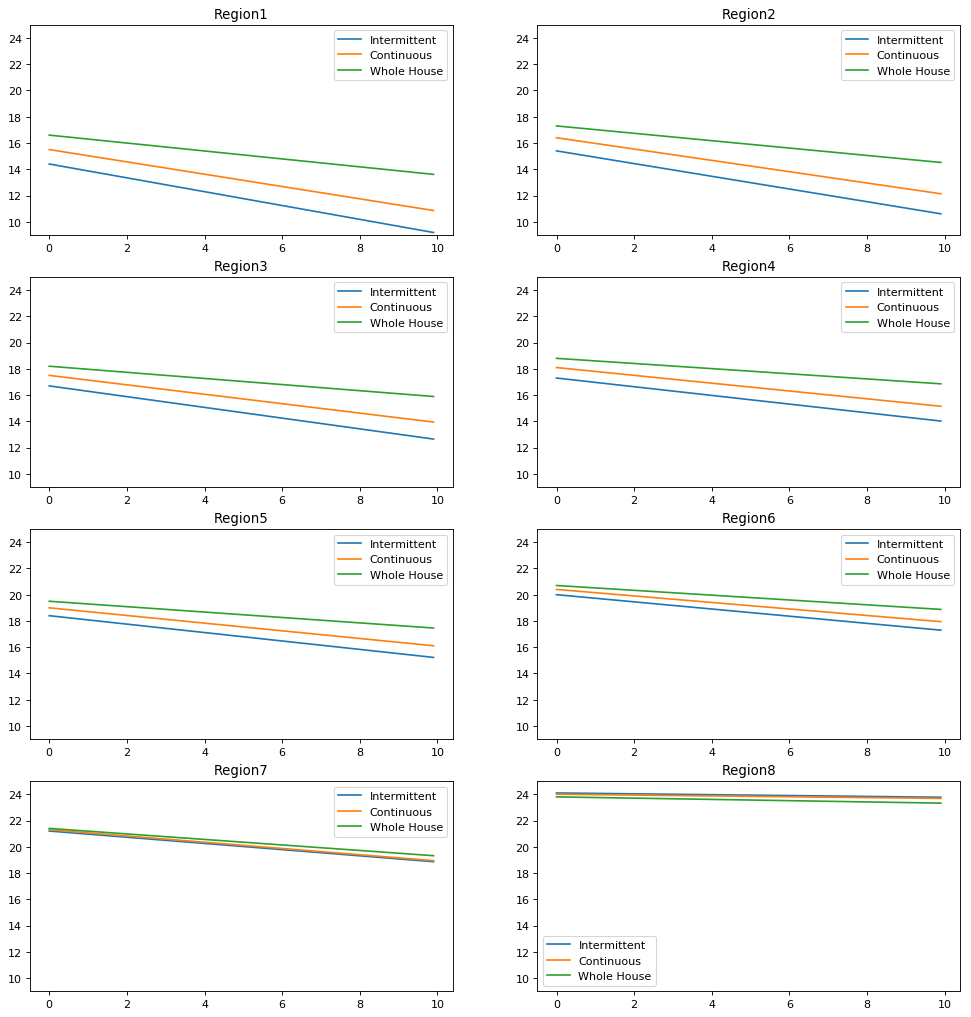

In [41]:
fignum = 8
xs = [ 0.1 * x for x in range(0,100) ]
plt.figure( figsize = (15,4*fignum/2), dpi=80 )
for i,r in enumerate(['Region1','Region2','Region3','Region4','Region5','Region6','Region7','Region8']):
    plt.subplot(fignum/2,2,i+1)
    ys1 = [ get_theta_uf_ave(x,r,'Intermittent_Intermittent') for x in xs ]
    ys2 = [ get_theta_uf_ave(x,r,'Continuous_Continuous') for x in xs ]
    ys3 = [ get_theta_uf_ave(x,r,'WholeHouse') for x in xs ]
    plt.plot(xs, ys1, label='Intermittent')
    plt.plot(xs, ys2, label='Continuous')
    plt.plot(xs, ys3, label='Whole House')
    plt.ylim(9.0,25.0)
    plt.title(r)
    plt.legend()
plt.show()

### 5.2 Ground Temperature Curve for a Year

Groud temperature curve in the case of Q value of 2.686.

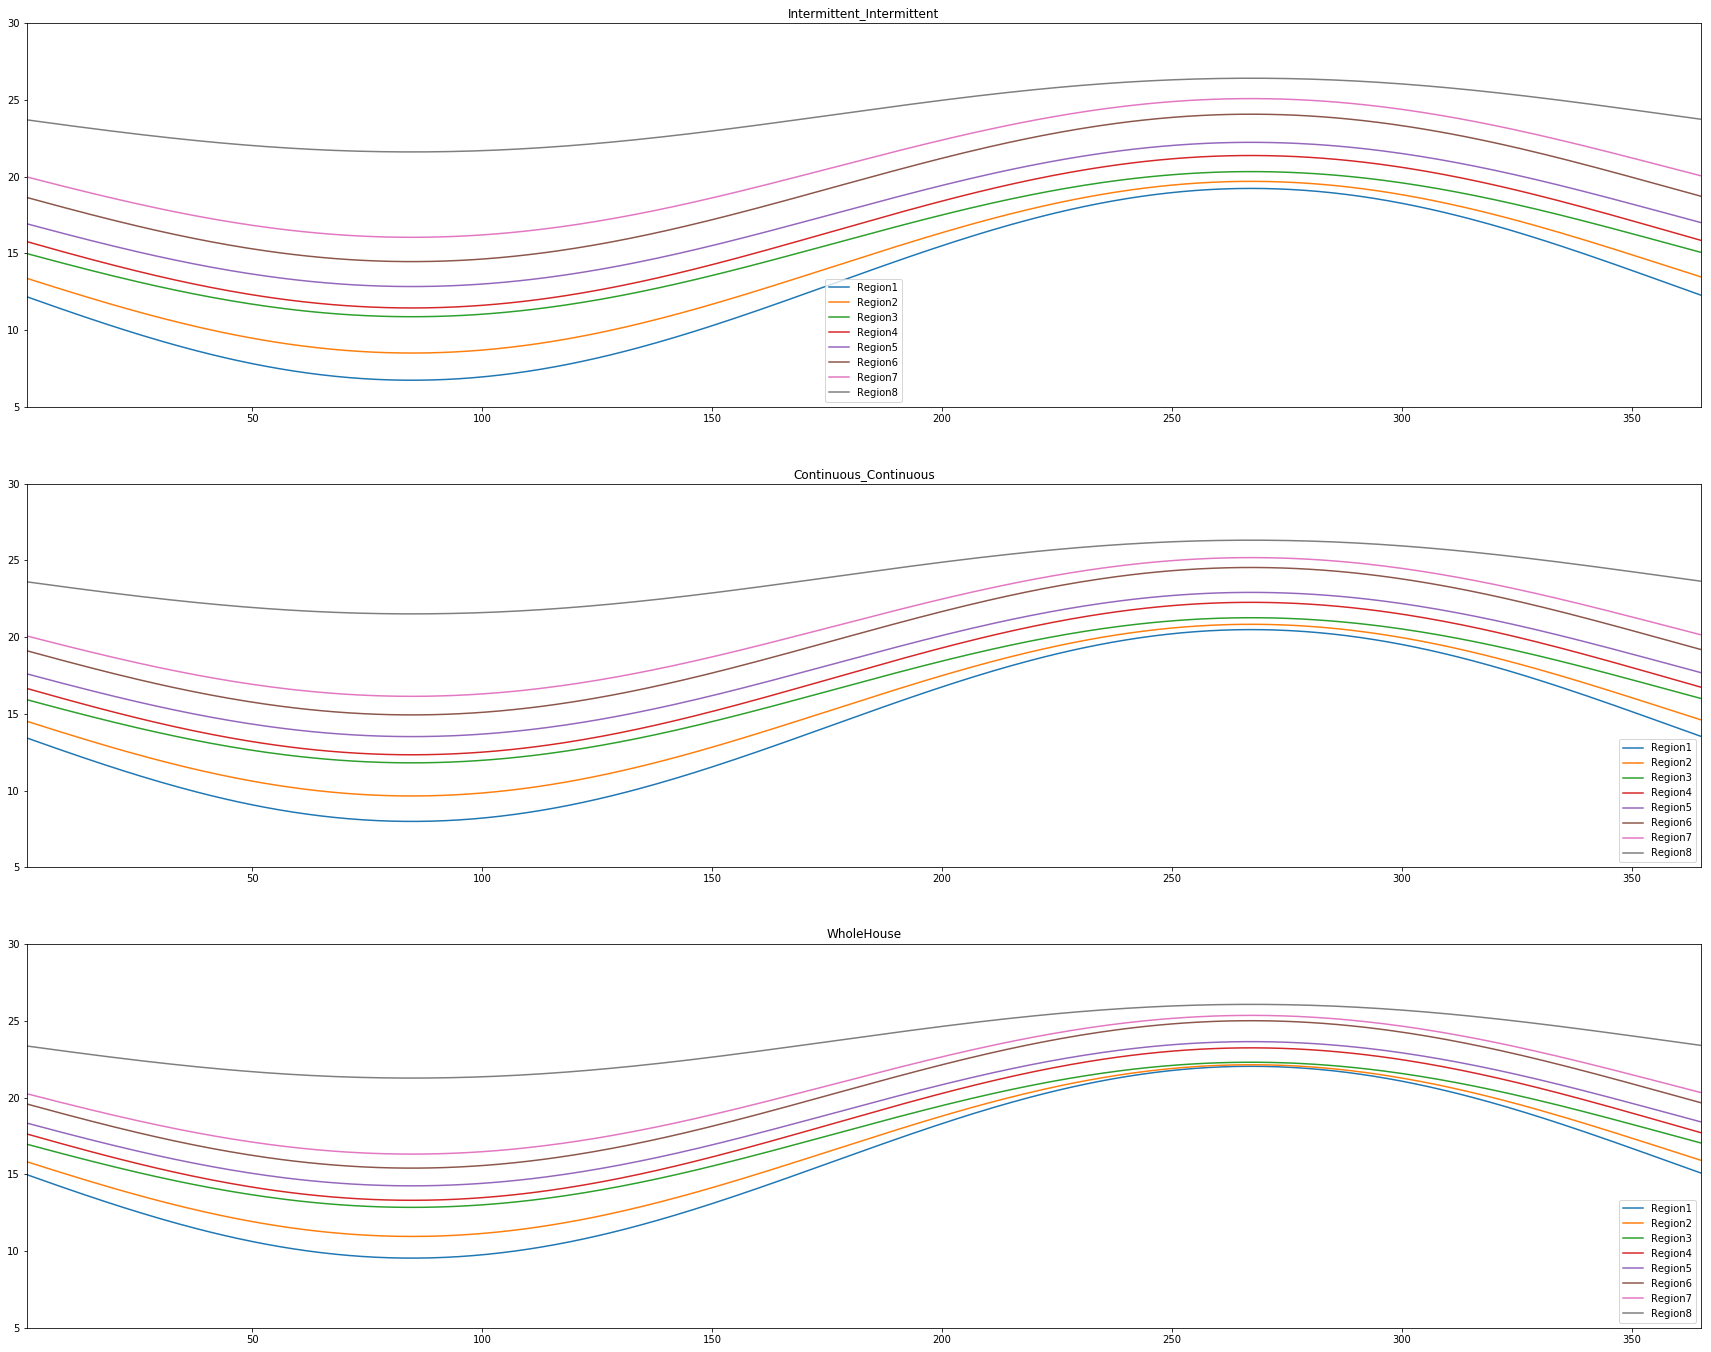

In [42]:
days = [ i + 1 for i in range(365) ]
def get_y(region,op,day):
    Q = 2.686
    t = get_theta_uf_ave(Q,region,op)
    return get_theta_g(t,region,day)
fignum = 3
plt.figure( figsize = ( 30, 8*fignum ) )
for i, op in enumerate(['Intermittent_Intermittent', 'Continuous_Continuous', 'WholeHouse']):
    plt.subplot(fignum,1,i+1)
    for r in ['Region1','Region2','Region3','Region4','Region5','Region6','Region7','Region8']:
        y = [ get_y(r,op,d) for d in days ]
        plt.plot(days,y,label=r)
    plt.xlim(1,365)
    plt.ylim(5.0,30.0)
    plt.title(op)
    plt.legend()
plt.show()


### 5.3 $Q$ Value vs. $U_{s,vert}$ Value

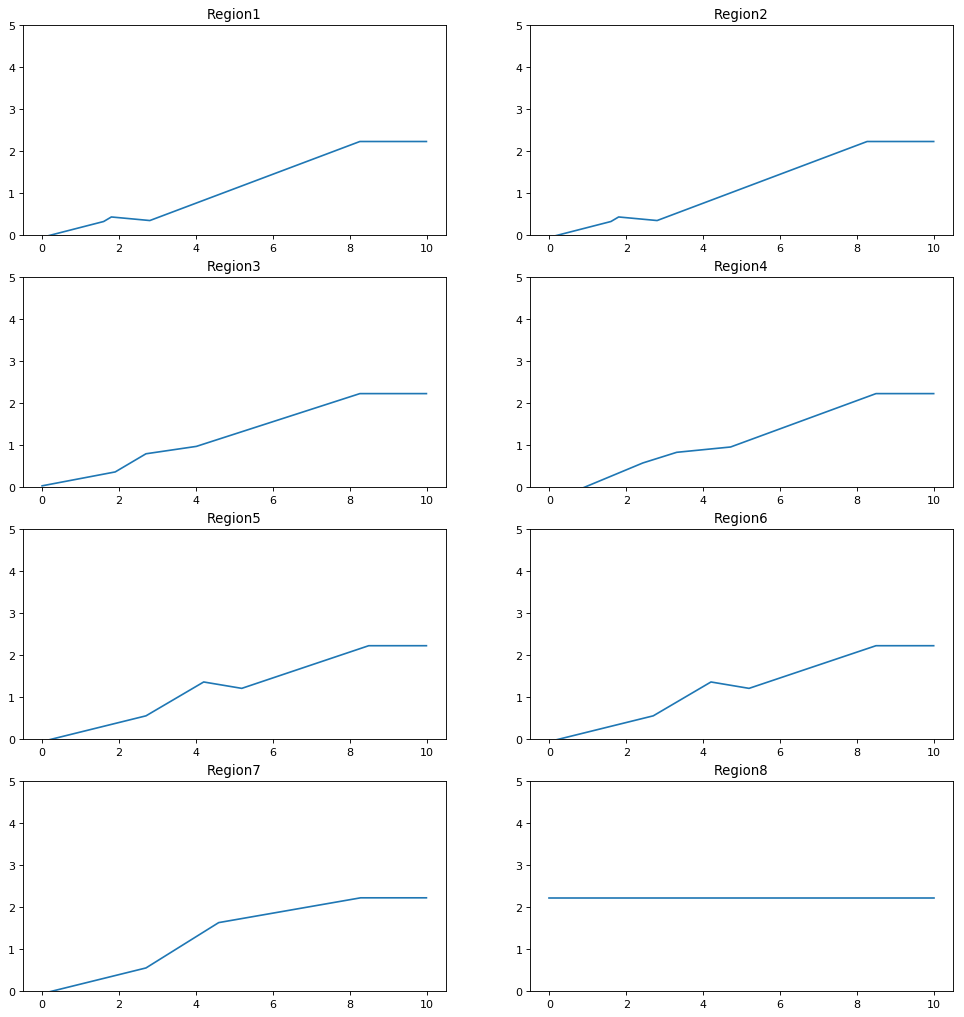

In [43]:
fignum = 8
xs = [ 0.01 * x for x in range(0,1000) ]
plt.figure( figsize = ( 15, 4*fignum/2 ), dpi=80 )
for i,r in enumerate(['Region1','Region2','Region3','Region4','Region5','Region6','Region7','Region8']):
    plt.subplot(fignum/2,2,i+1)
    ys = [ get_U_s_vert(r,x) for x in xs ]
    plt.plot(xs, ys)
    plt.ylim(0.0,5.0)
    plt.title(r)
plt.show()

### 5.4 $Q$ Value vs. $\psi$ Value

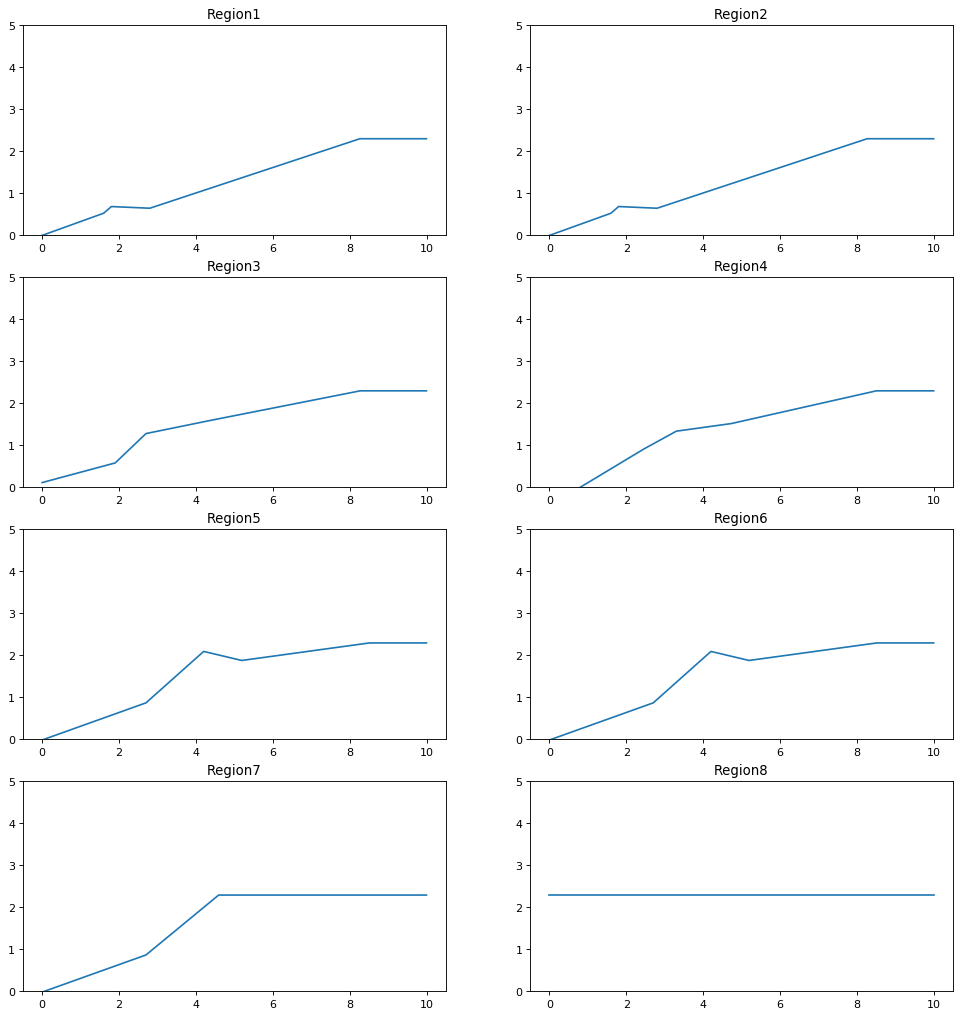

In [44]:
fignum = 8
xs = [ 0.01 * x for x in range(0,1000) ]
plt.figure( figsize = ( 15, 4*fignum/2 ), dpi=80 )
for i,r in enumerate(['Region1','Region2','Region3','Region4','Region5','Region6','Region7','Region8']):
    plt.subplot(fignum/2,2,i+1)
    ys = [ get_psi(r,x) for x in xs ]
    plt.plot(xs, ys)
    plt.ylim(0.0,5.0)
    plt.title(r)
plt.show()

### 5.5 Under floor space temperature

In [45]:
def show_annual_underfloor_temp(region, r_UFArea, Q, OperationMode, nRoom):

    def calc_underfloor_temp(region, r_UFArea, Q, OperationMode, day, hour, HCSeason, nRoom):
        
        r_A_s_uf = get_r_A_s_uf()
        
        A_HCZ = HCFA.get_A_HCZ( A_A = 120.08, A_MR = 30.0, A_OR = 45.0 ) # ← ここ修正する必要あり
        
        # floor area on under floor space with air intake in the standard house
        A_s_ufvnt = get_A_s_ufvnt( r_UFArea, A_HCZ, r_A_s_uf )
        A_s_ufvnt_A = get_A_s_ufvnt_A(A_s_ufvnt)
    
        U_s_vert = get_U_s_vert(region, Q)
        
        psi = get_psi(region, Q)

        V_A = get_V_A( A_A = 120.08 )
        V = get_V( V_A = V_A, A_MR = 30.0, A_OR = 45.0, A_HCZ = A_HCZ )

        # ground temperature
        theta_g = get_ground_temperature(region, Q, OperationMode, day)
        
        L_dash_H_s = LWT.get_L_dash_H_s(day, hour)
        L_dash_CS_s =  LWT.get_L_dash_CS_s(day, hour)
        H_aster_s = [get_H_aster(L_dash_H_s[i], L_dash_CS_s[i]) for i in range(0,12,1)]
        theta_aster_s =  [get_theta_aster(L_dash_H_s[i], L_dash_CS_s[i], theta_ex = 7.2) for i in range(0,12,1)]
        theta_ex = EC.get_temperature(region, day, hour)
        theta_sa = theta_ex
        
        return np.average( np.array( [
            get_underfloor_temp(120.08, theta_sa, A_s_ufvnt,  H_aster_s,theta_aster_s, psi, A_s_ufvnt_A, theta_g, theta_ex)
        ]) )
    
    plt.figure( figsize = (30, 8) )

    days = [ i + 1 for i in range(365) ]
    
    tempH = [ calc_underfloor_temp(region, r_UFArea, Q, OperationMode, EC.get_Annual_Days()[day-1], 1, 'heating', nRoom) for day in days ]
    tempC = [ calc_underfloor_temp(region, r_UFArea, Q, OperationMode, EC.get_Annual_Days()[day-1], 1, 'cooling', nRoom) for day in days ]
    
    plt.plot(days,tempH, label='heating')
    plt.plot(days,tempC, label='cooling')
    plt.xlim(1,365)
    plt.legend()
    plt.show()

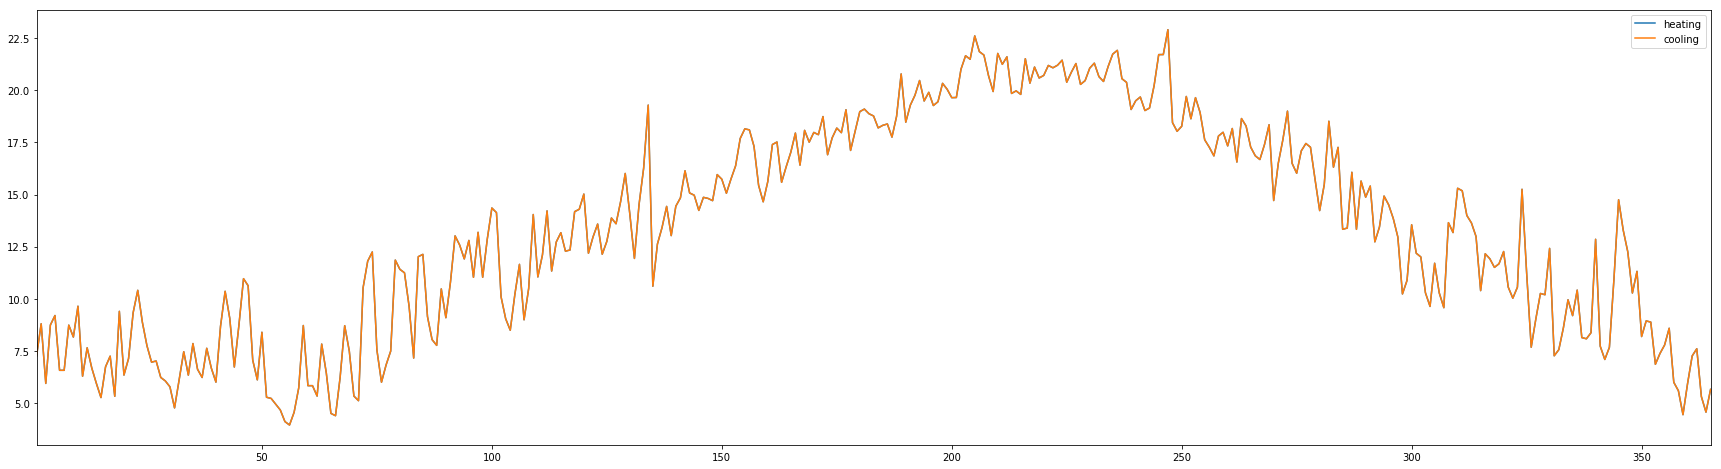

In [46]:
show_annual_underfloor_temp('Region6', 0.5, 2.686289141, 'Intermittent_Intermittent', 0)

### 5.6 Annual Heating or Cooling Load Reduction

In [47]:
def show_annual_HC_load_reduction(spec, nRoom):
    
    def sum_daily_HC_load_reduction(spec, day, HCSeason, nRoom):
        return np.sum( np.array( [
            get_hourly_HC_load_reduction(spec, day, h, HCSeason, nRoom) for h in range(24)
        ] ) )
    
    plt.figure( figsize = (30, 8) )

    days = [ i + 1 for i in range(365) ]
    
    loadH = [ sum_daily_HC_load_reduction(spec, EC.get_Annual_Days()[d-1], 'heating', nRoom) for d in days ]
    loadC = [ sum_daily_HC_load_reduction(spec, EC.get_Annual_Days()[d-1], 'cooling', nRoom) for d in days ]
        
    plt.plot(days,loadH, label='heating')
    plt.plot(days,loadC, label='cooling')
    plt.xlim(1,365)
    plt.legend()
    plt.show()

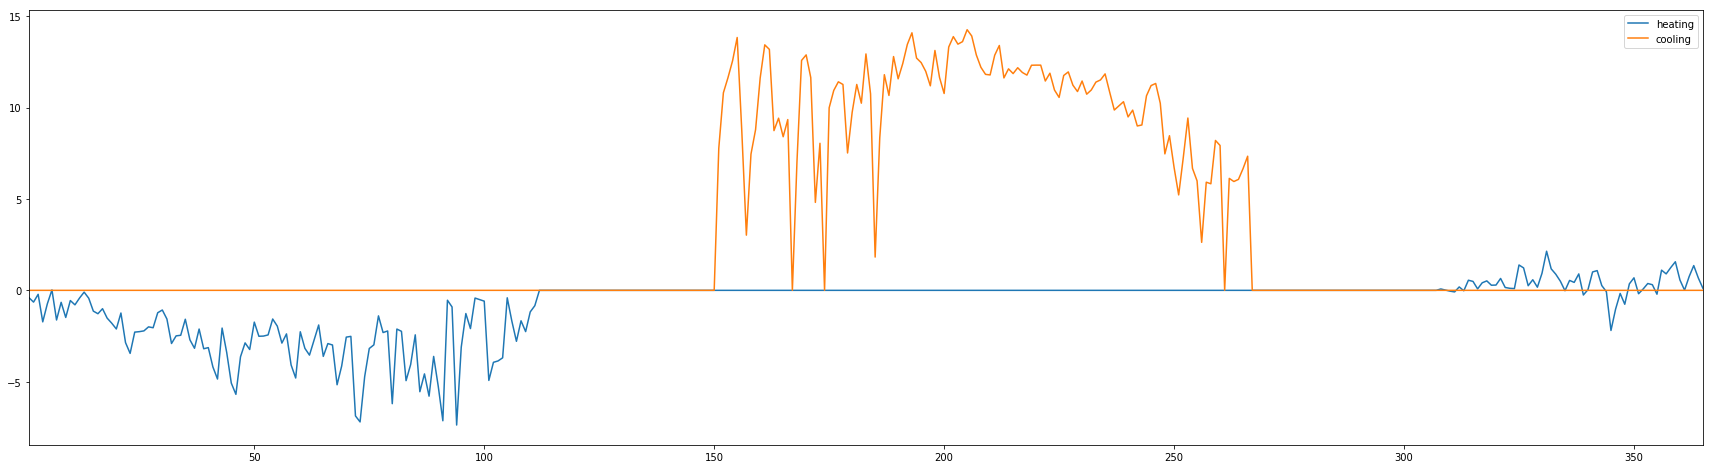

In [48]:
show_annual_HC_load_reduction({'total_floor_area':120.08,
                               'region':'Region6',
                               'main_floor_area' : 30.0,
                               'other_floor_area' : 45.0,
                               'utilizing_mode':2,
                               'utilizing_area_rate':50.0,
                               'Q_value':2.686289141,
                               'operation_mode':'Intermittent_Intermittent'}, 0)